In [1]:
%cd ..

/home/ubuntu/dev/edge/py-edge-eval


In [2]:
import os

# imports
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
# %matplotlib widget

In [4]:
ROOT = os.path.join('data', 'cityscapes')
gtFine = os.path.join(ROOT, 'gtFine')
gtEval = os.path.join(ROOT, 'gtEval')

# extensions:
seg_color_ext = "gtFine_color.png"
img_ext = "leftImg8bit.png"
inst_ext = "gtFine_instanceIds.png"
label_ext = "gtFine_labelIds.png"
poly_ext = "gtFine_polygons.json"
edge_ext = "gtProc_edge.png"  # NOTE: instance insensitive
isedge_ext = "gtProc_isedge.png"  # NOTE: instance sensitive
seg_ext = "gtFine_labelTrainIds.png"

In [18]:
# sampe:
split = 'val'
city = "frankfurt"
frameid = "000000_000576"

img_path = os.path.join(gtFine, split, city, f"{city}_{frameid}_{seg_color_ext}")
assert os.path.exists(img_path)
label_path = os.path.join(gtEval, split, city, f"{city}_{frameid}_{seg_ext}")
edge_path = os.path.join(gtEval, split, city, f"{city}_{frameid}_{edge_ext}")
assert os.path.exists(edge_path) and os.path.exists(label_path)

In [19]:
from pyEdgeEval.datasets.cityscapes.edge_encoding import rgb_decoding

In [20]:
scale = 0.5

(19, 512, 1024) (512, 1024)


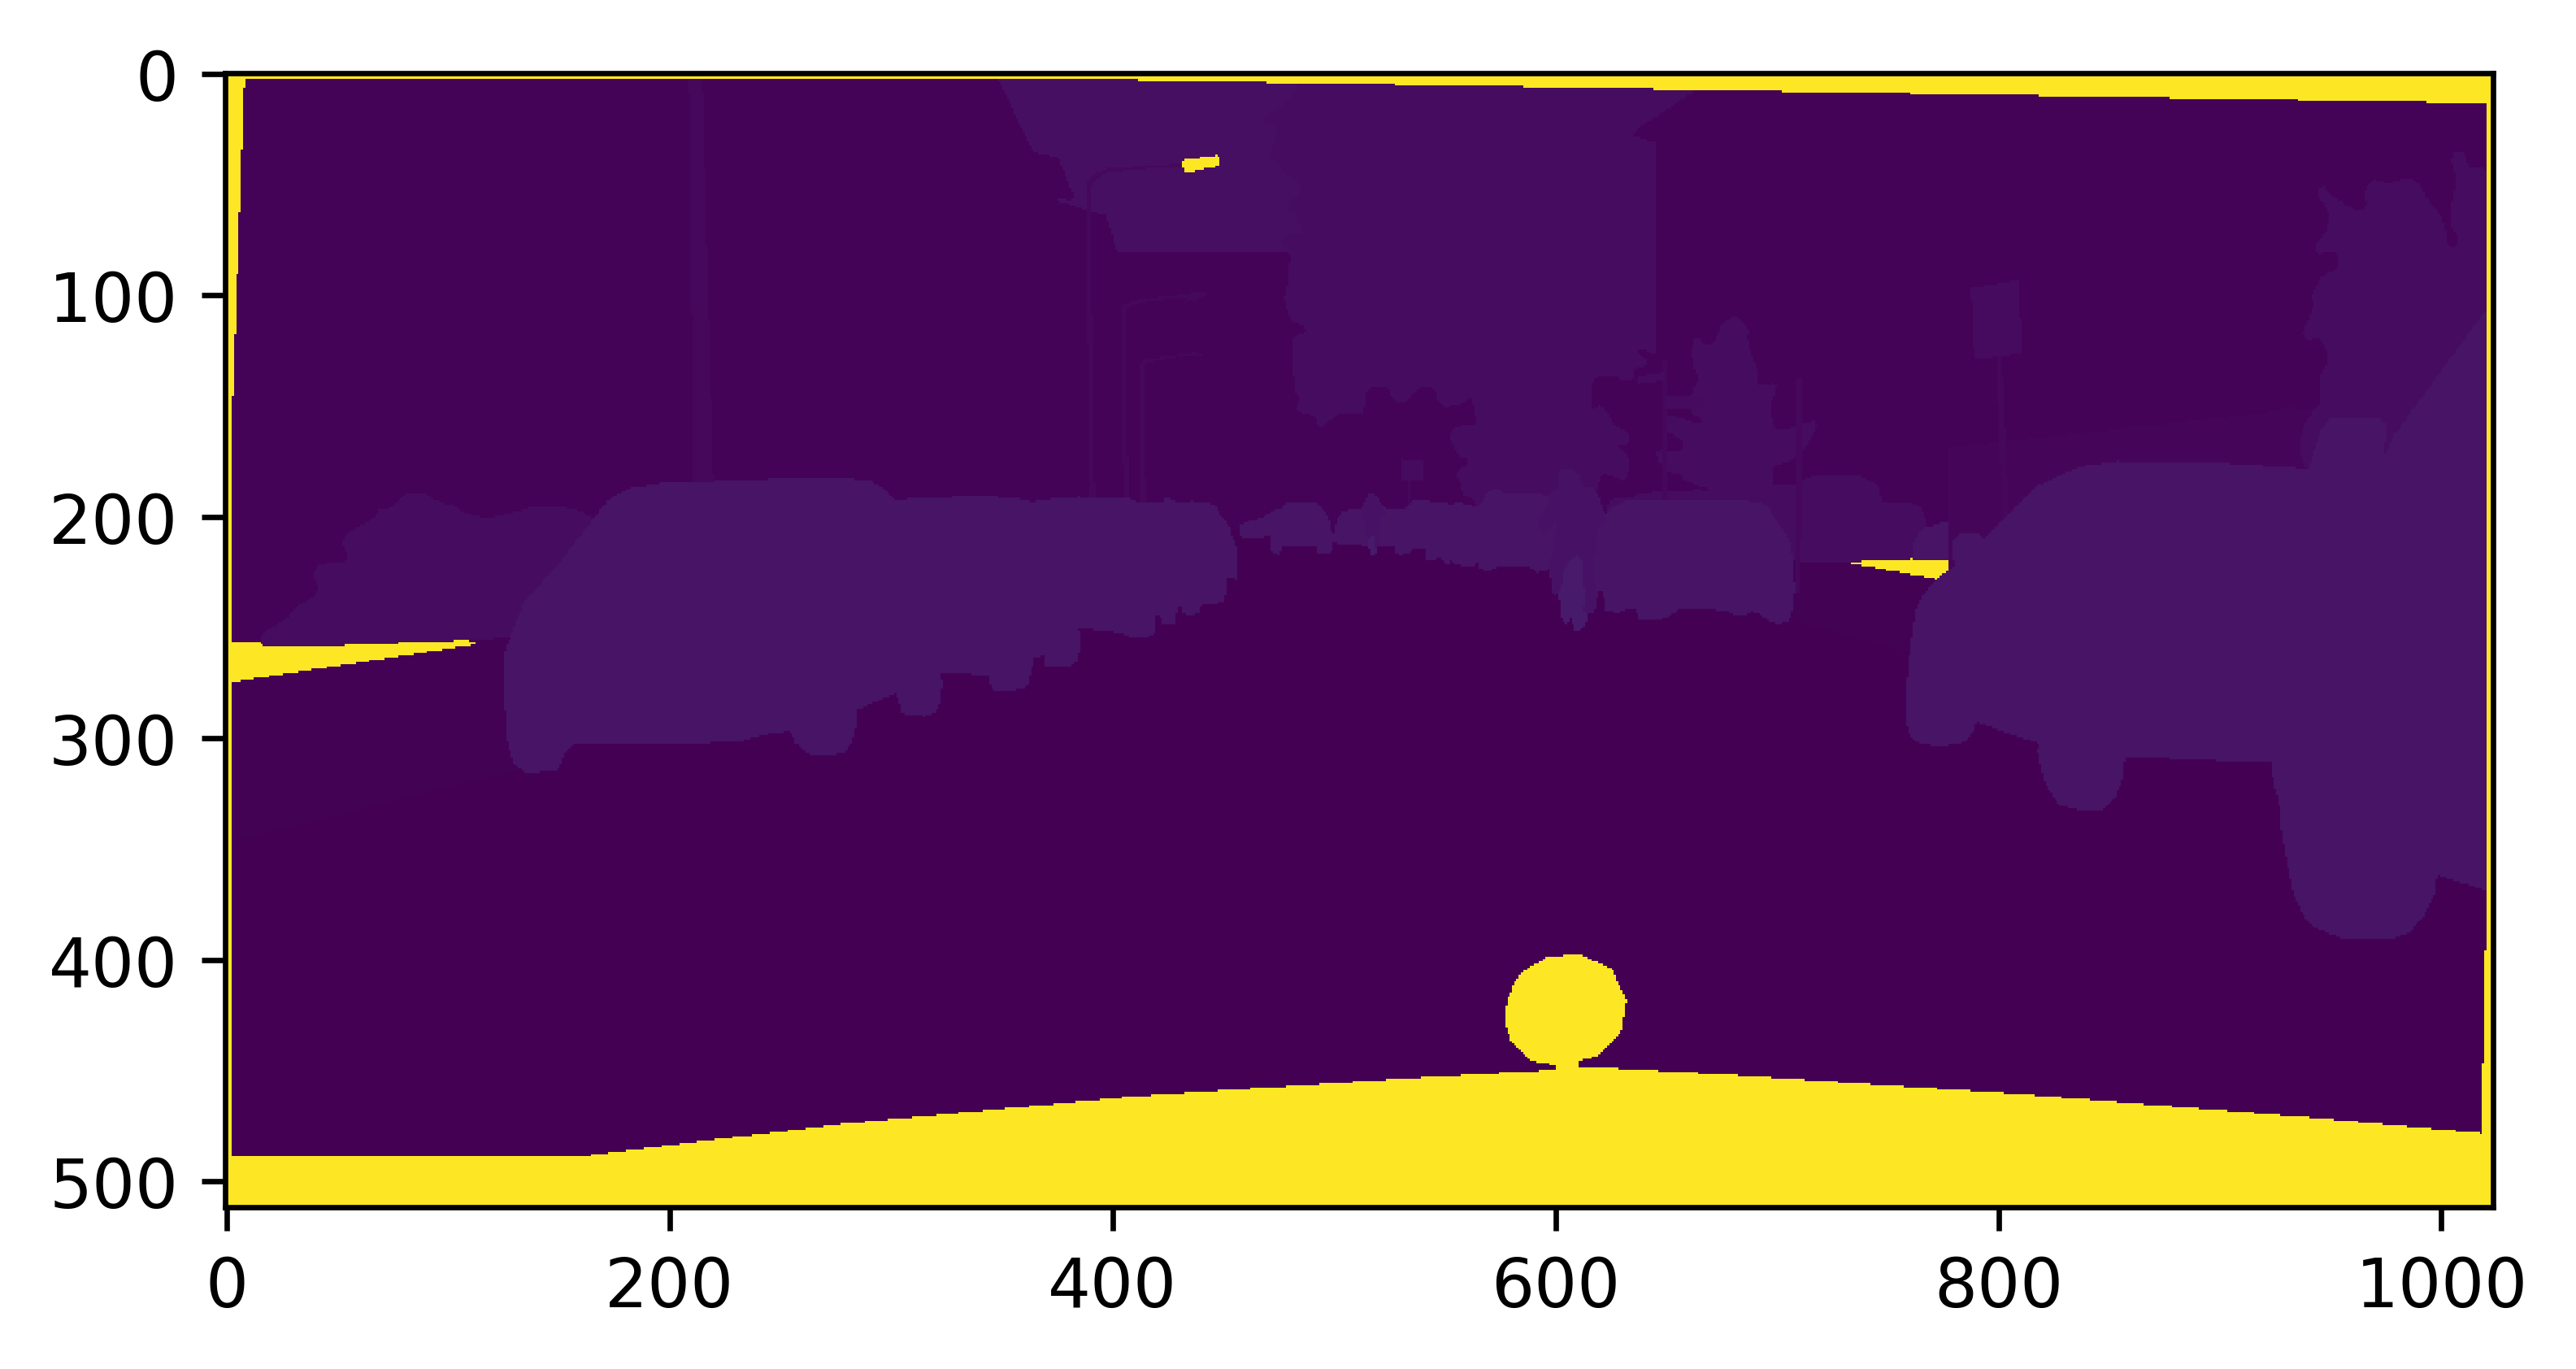

In [21]:
mask = Image.open(label_path)
_mask = np.array(mask)
(h, w) = _mask.shape
oh, ow = int(h * scale + 0.5), int(w * scale + 0.5)
mask = mask.resize((ow, oh), Image.NEAREST)
mask = np.array(mask)

edge = rgb_decoding(
    edge_path=edge_path,
    num_trainIds=19,
    scale=0.5,
    is_png=True,
)

print(edge.shape, mask.shape)

plt.imshow(mask, interpolation='nearest')
plt.gcf().set_dpi(600)
plt.show()

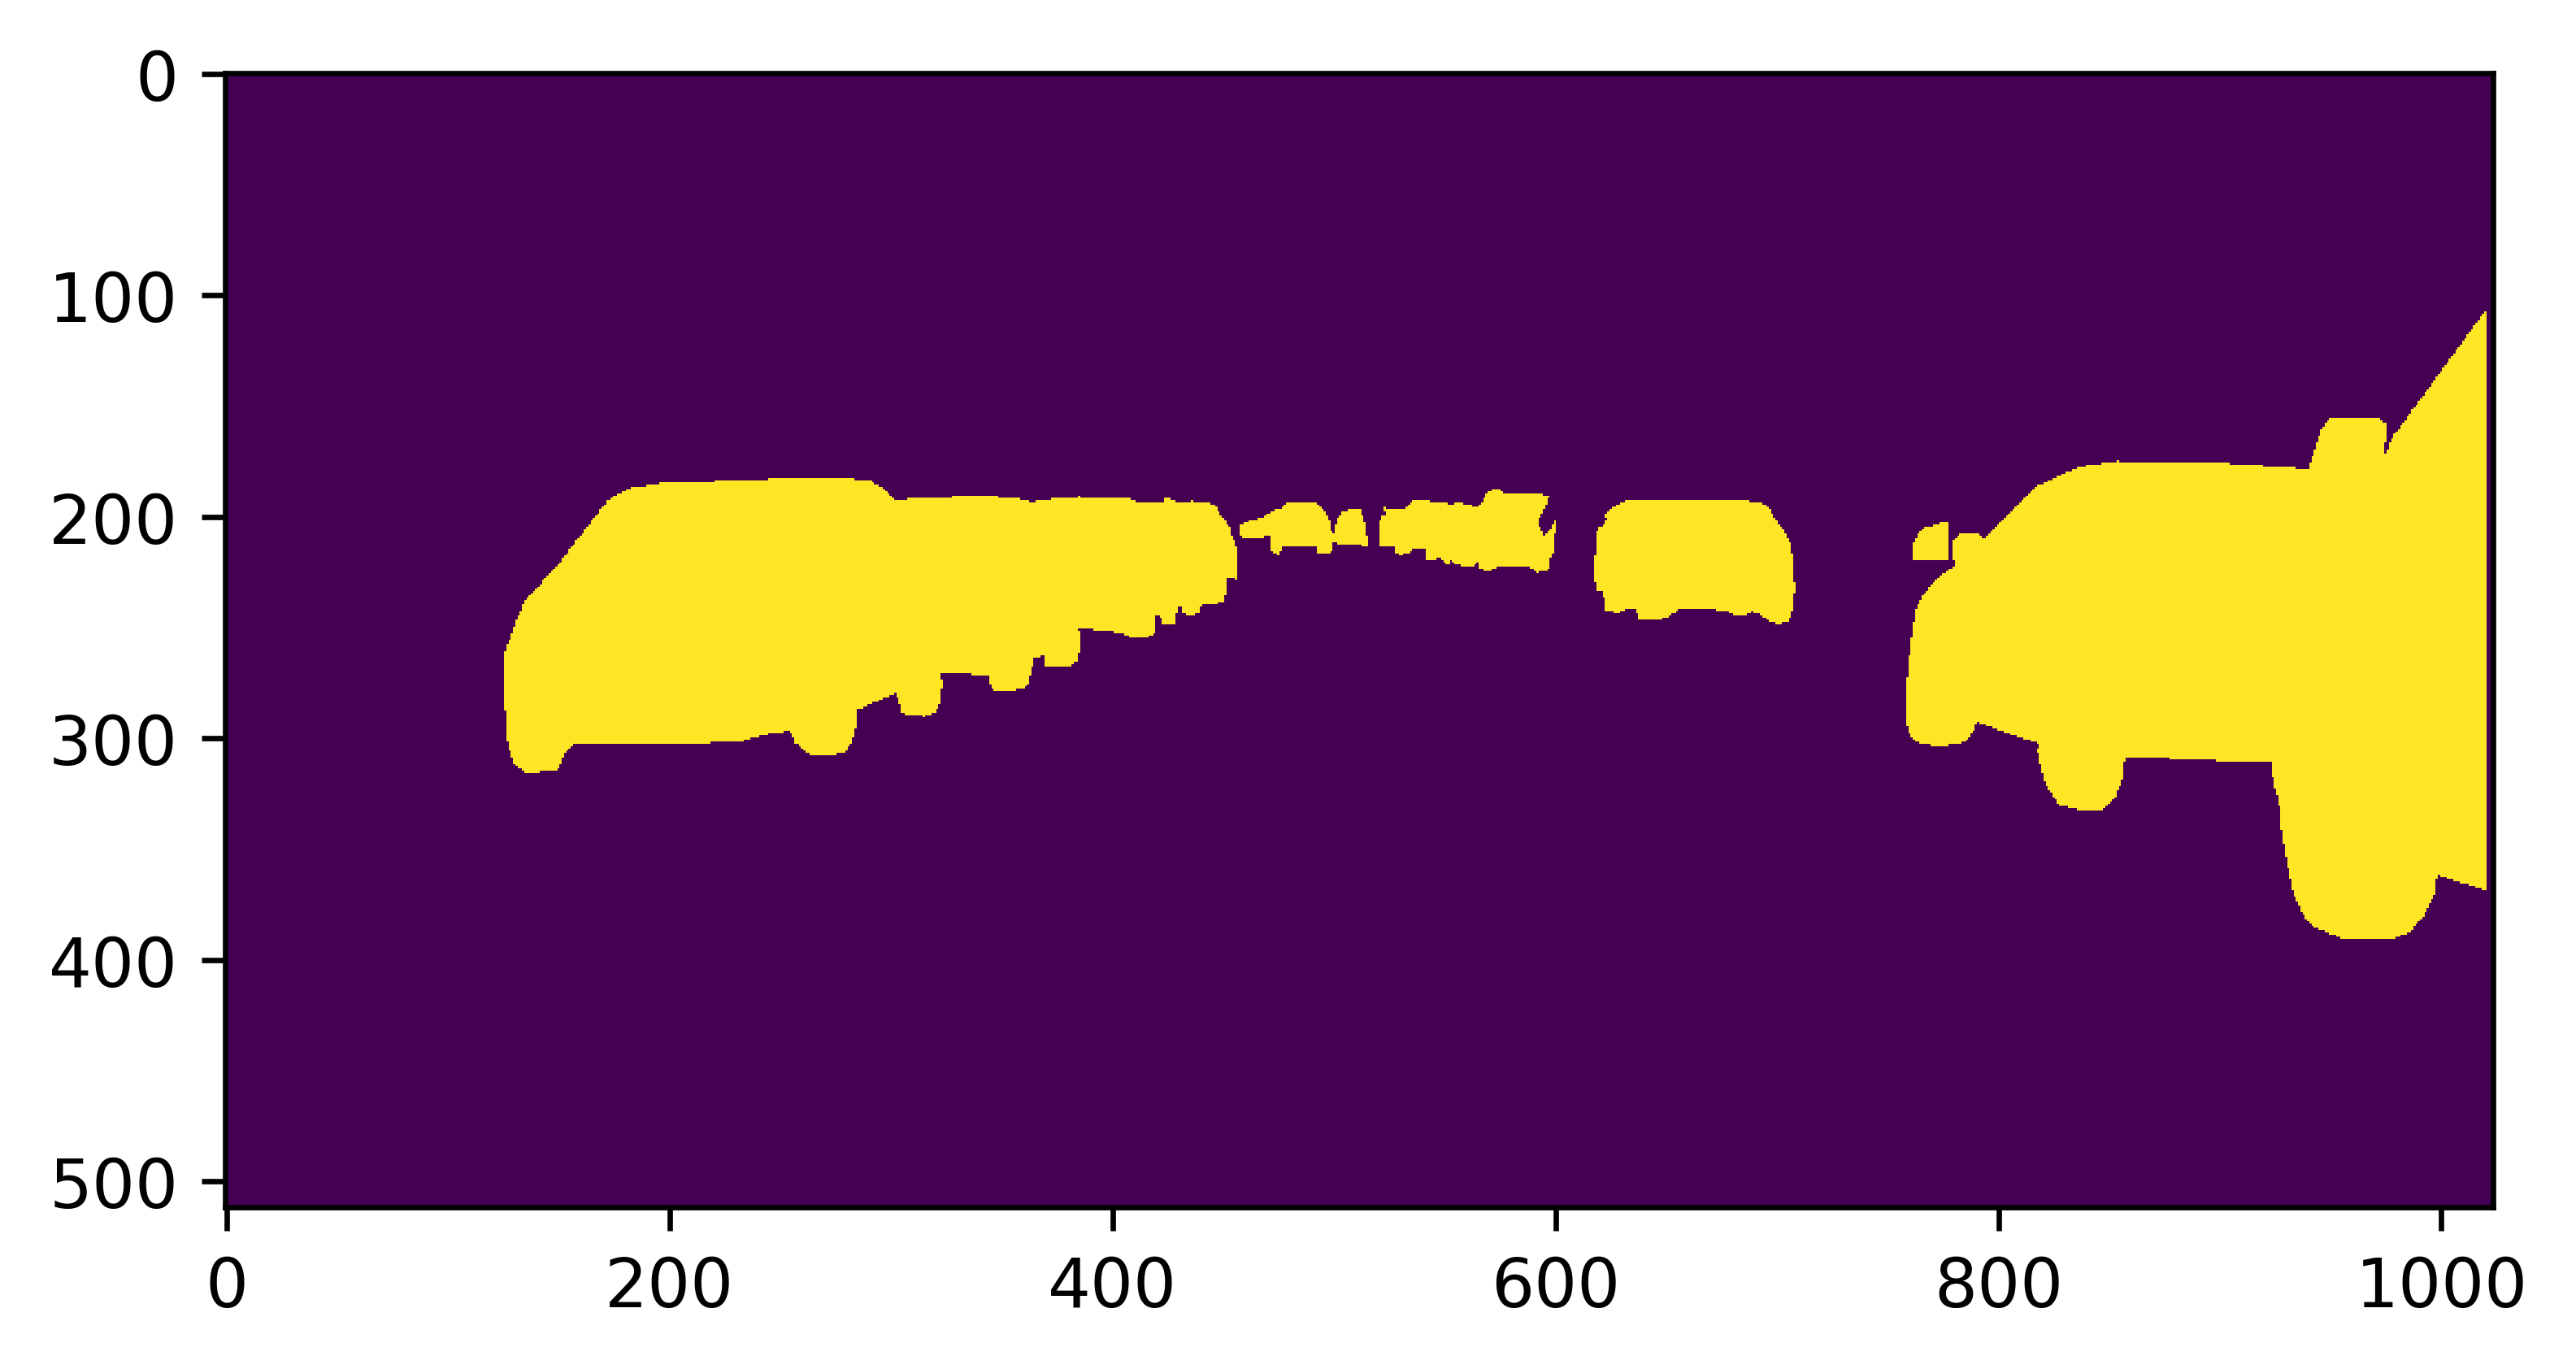

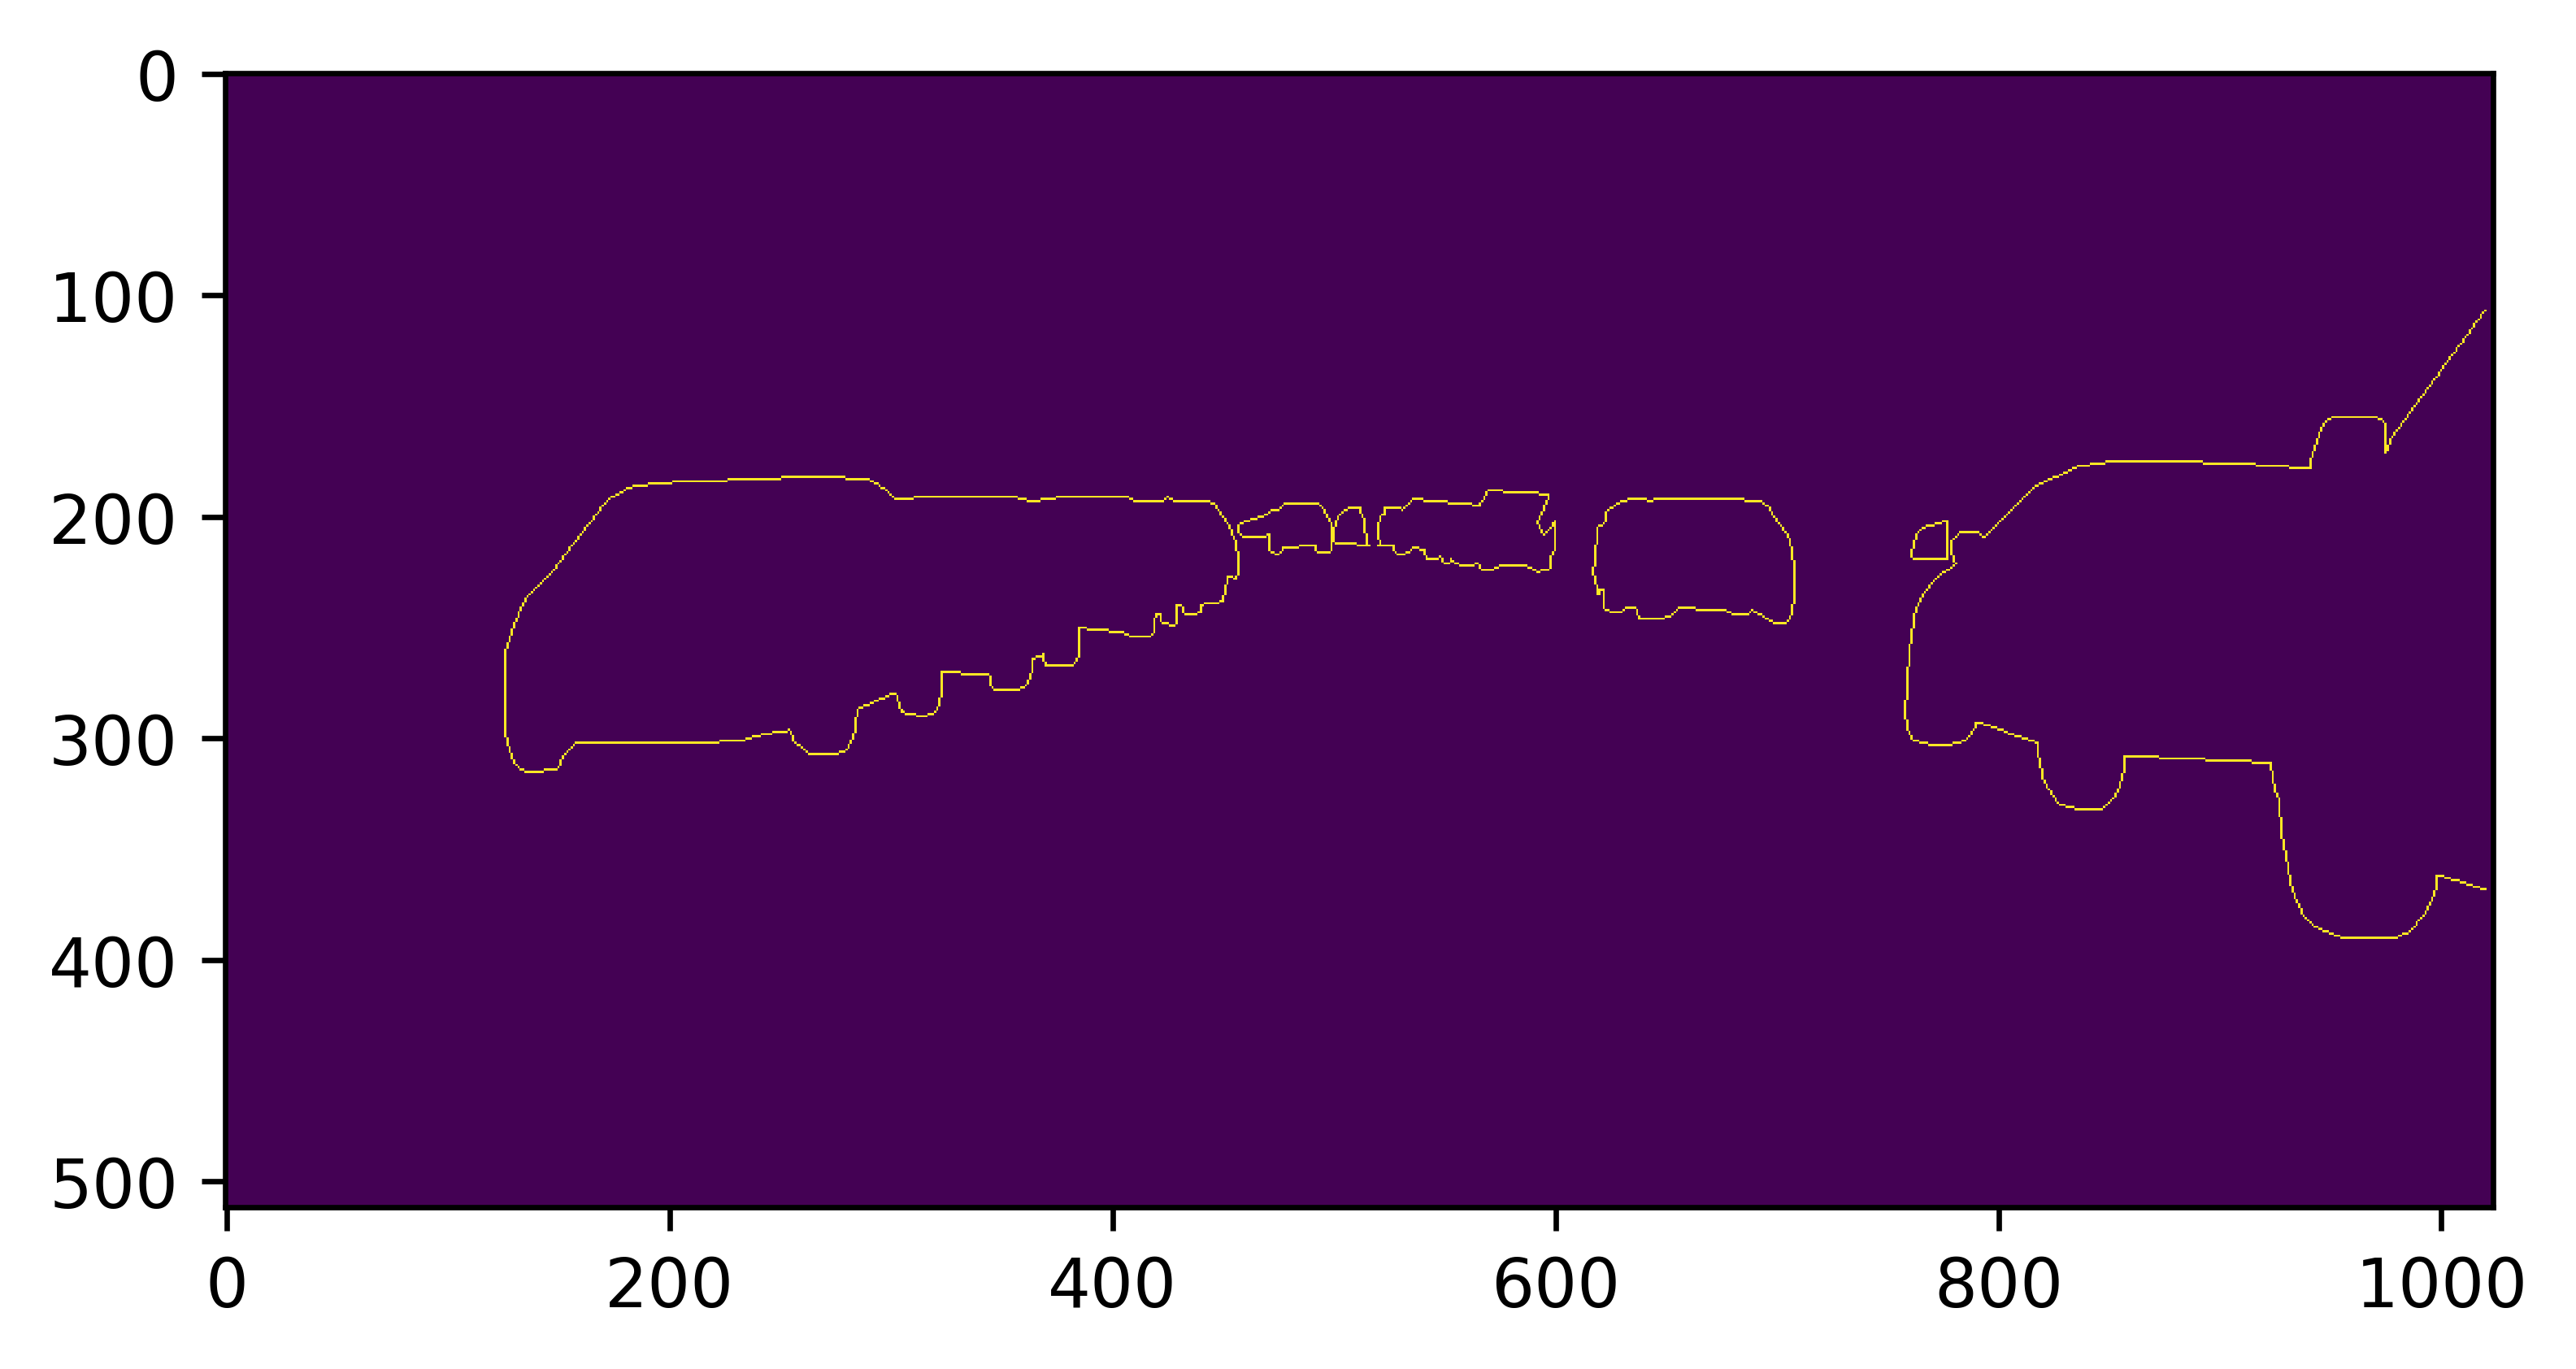

In [22]:
cat = 13

plt.imshow(mask == cat, interpolation='nearest')
plt.gcf().set_dpi(600)
plt.show()

plt.imshow(edge[cat], interpolation='nearest')
plt.gcf().set_dpi(600)
plt.show()

check predictions:

In [10]:
pred_root = os.path.join(
    'data',
    'cityscapes_results',
    'dff',
    'trained_resnet101_val',
    'fuse',
    f'class_{str(cat + 1).zfill(3)}',  # indexed from 1
)
assert os.path.exists(pred_root)

In [11]:
pred_file = os.path.join(pred_root, f'{city}_{frameid}_{img_ext}')
pred = Image.open(pred_file)

_pred = np.array(pred)
(h, w) = _pred.shape
oh, ow = int(h * scale + 0.5), int(w * scale + 0.5)
pred = pred.resize((ow, oh), Image.NEAREST)

pred = np.array(pred) / 255

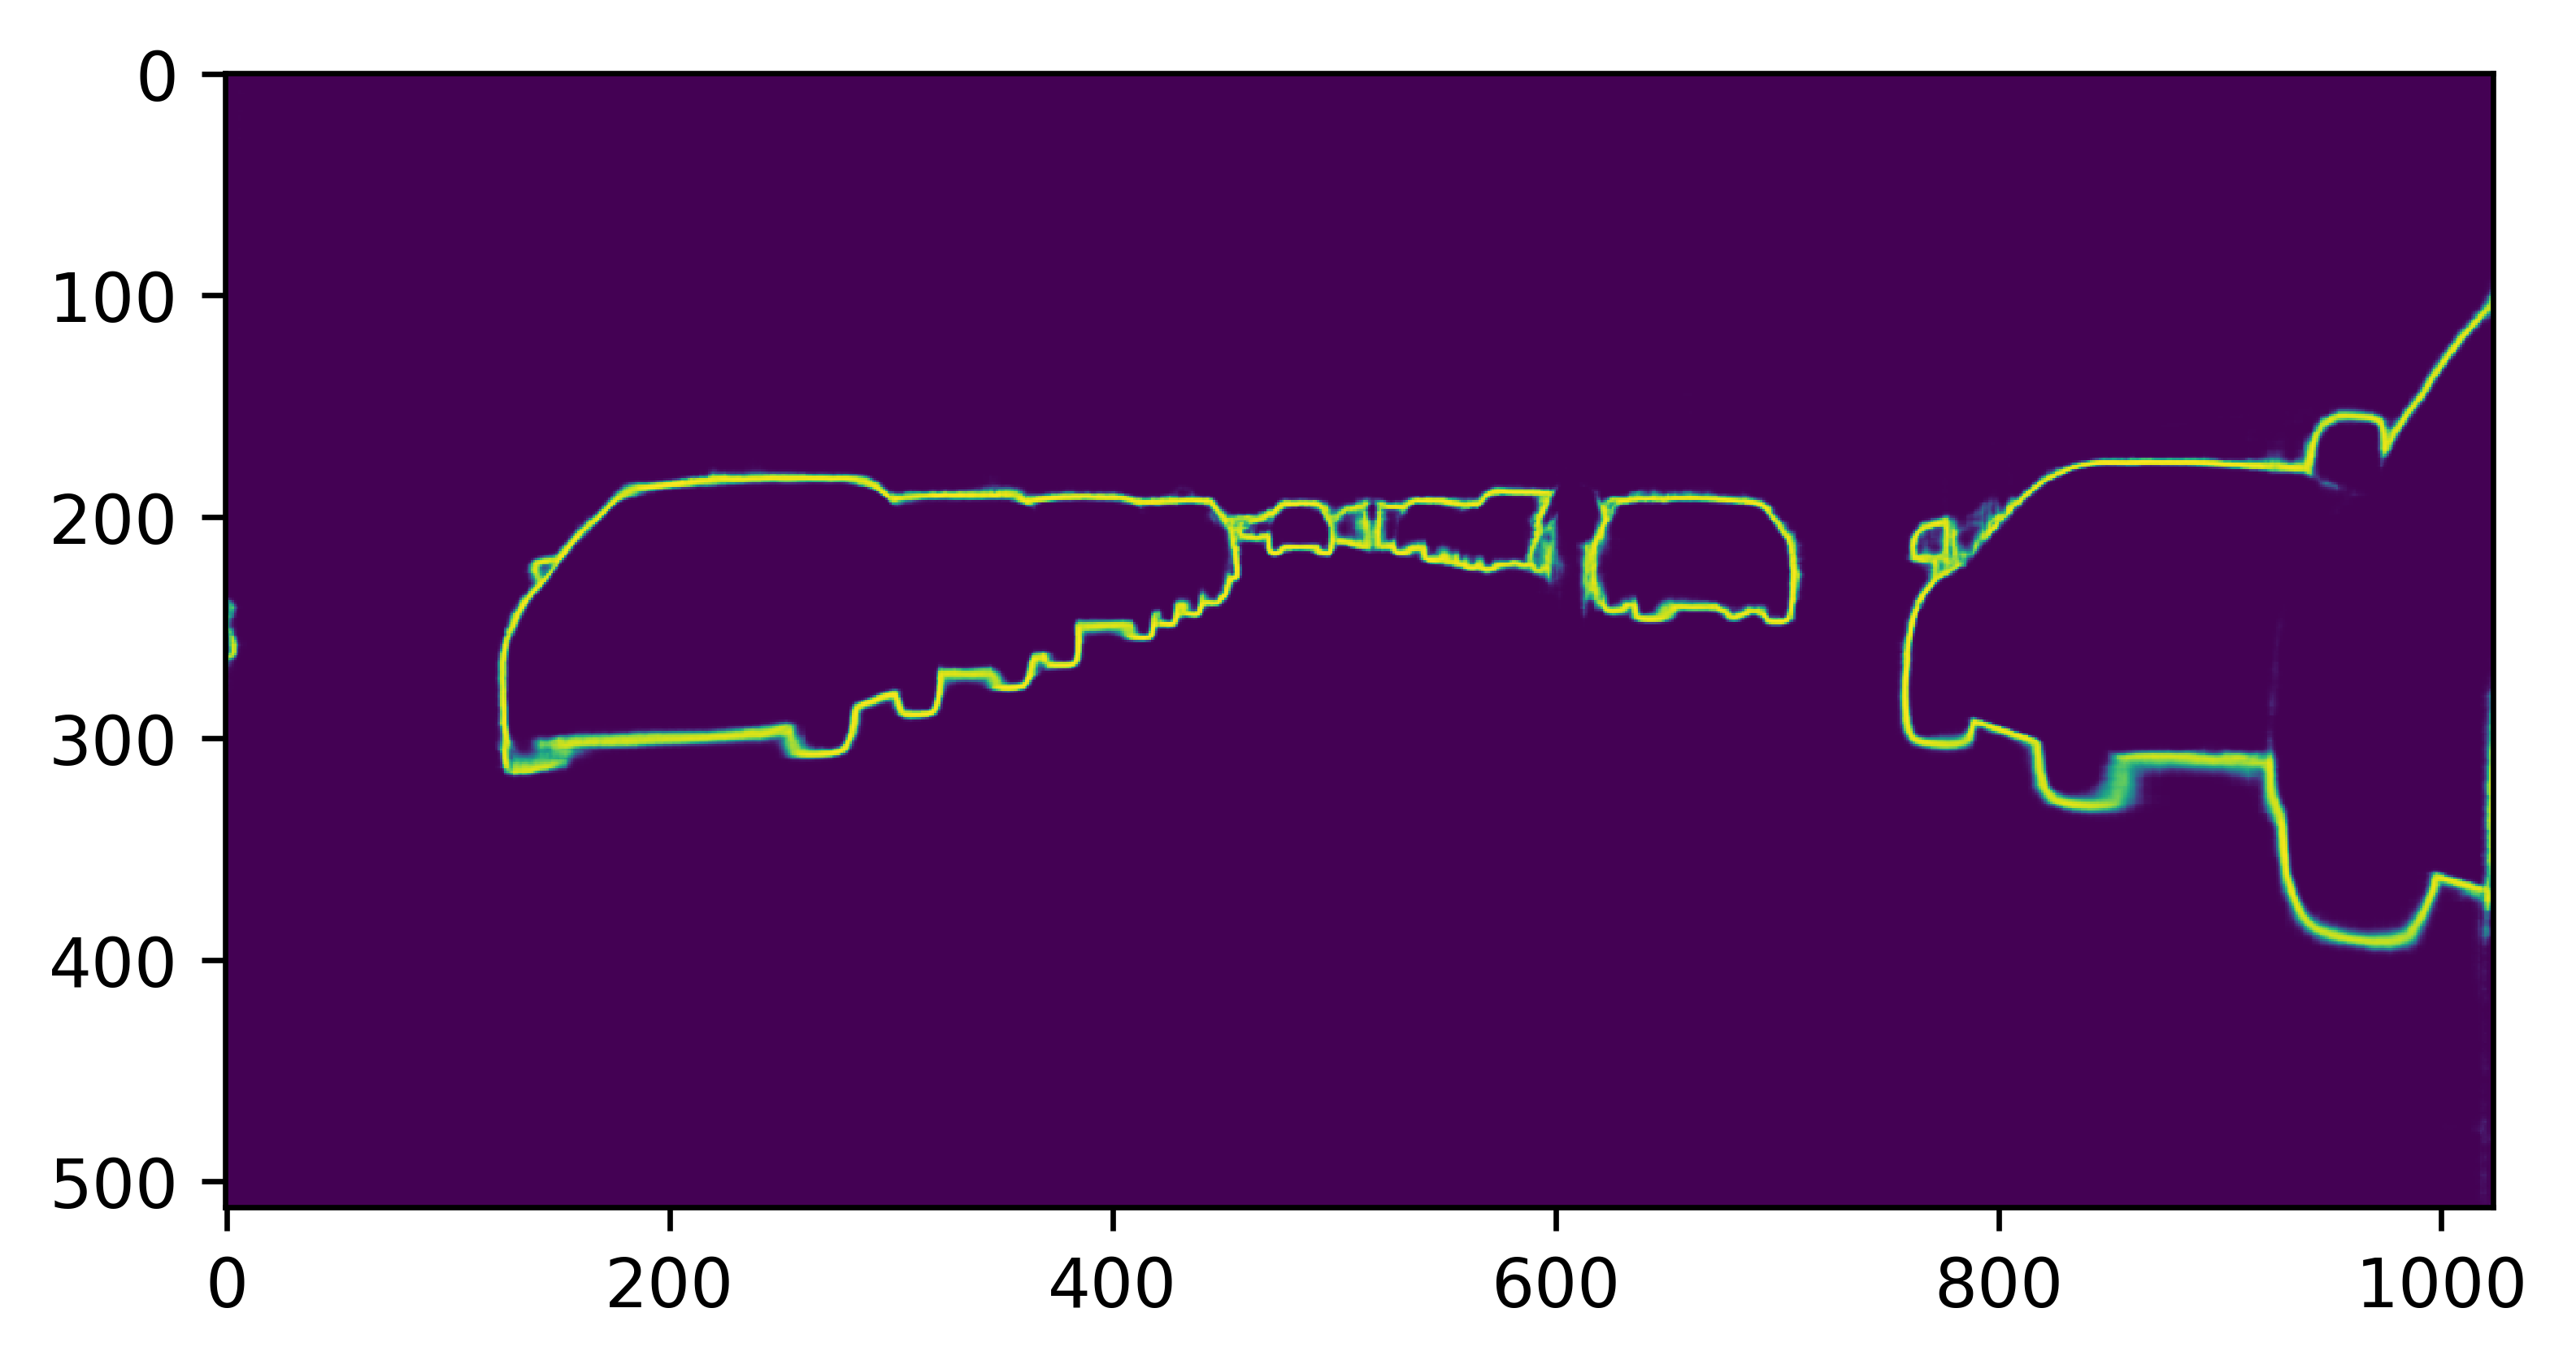

In [12]:
plt.imshow(pred, interpolation='nearest')
plt.gcf().set_dpi(600)
plt.show()

for now, using `--raw` is way better than using `thin`
need to investigate why this is.

`--raw` performance is <10% lower than expected, but is >30% than MATLAB's raw performance

In [78]:
from pyEdgeEval.preprocess.thin import binary_thin, bwmorph_thin

thrs = 0.5

t_pred = pred >= thrs

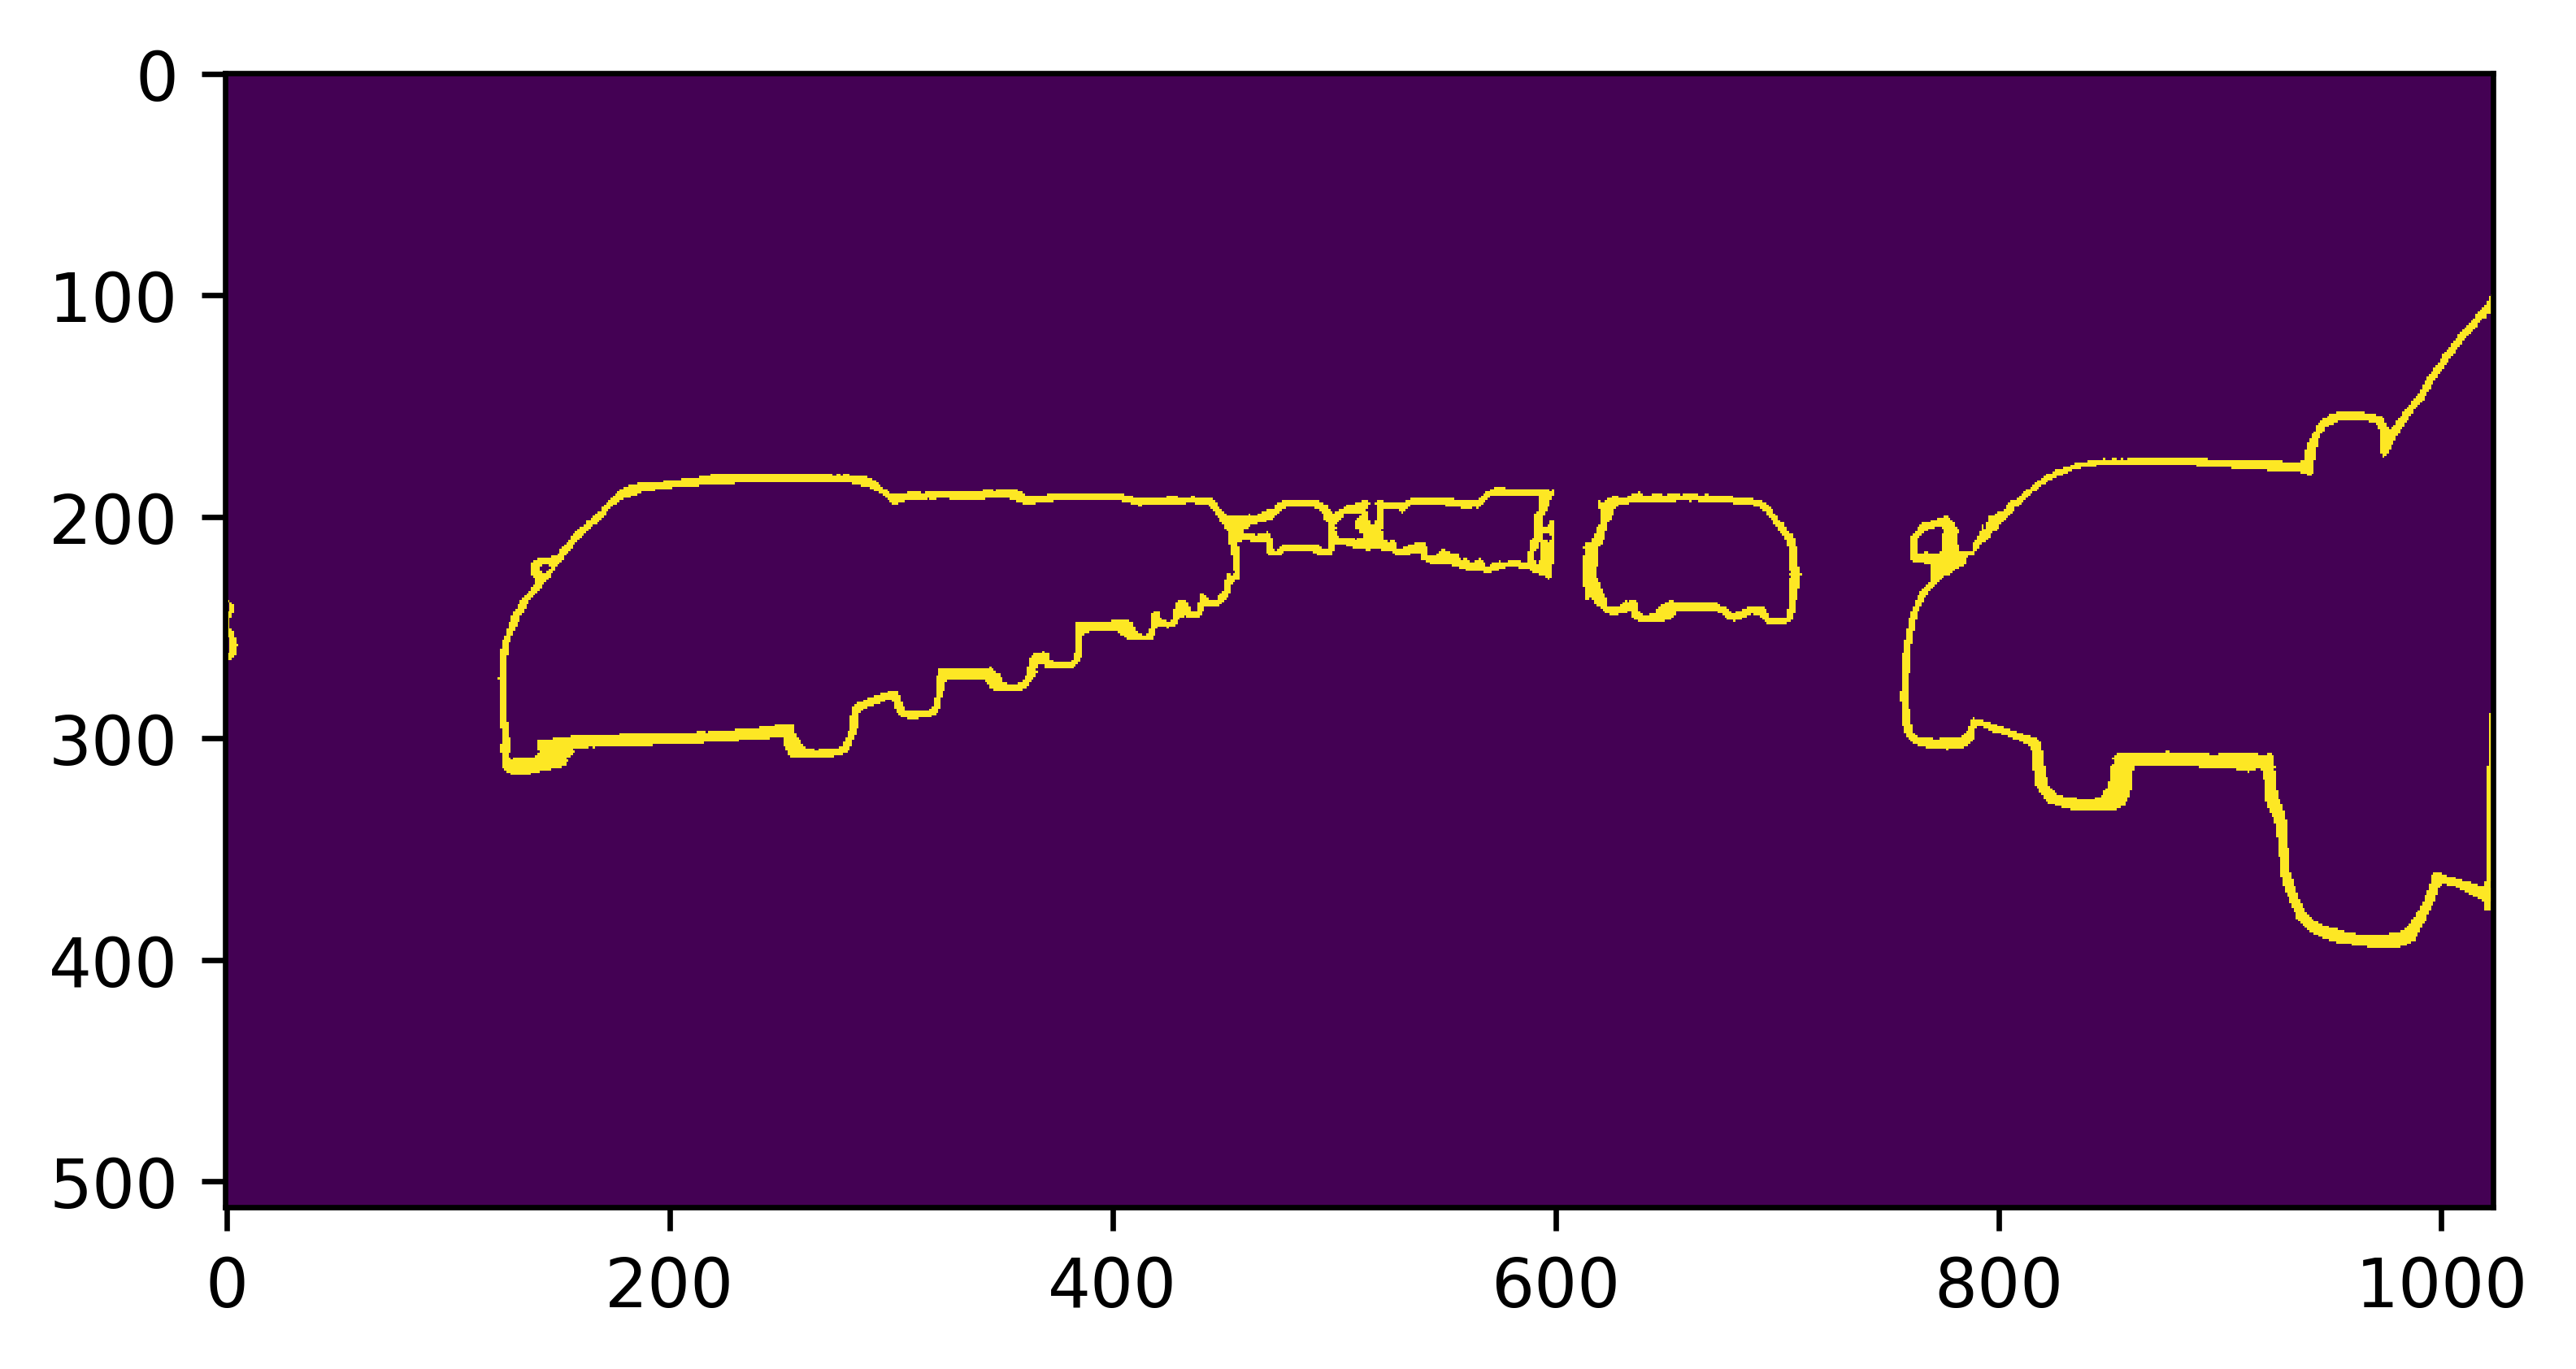

In [79]:
plt.imshow(t_pred, interpolation='nearest')
plt.gcf().set_dpi(600)
plt.show()

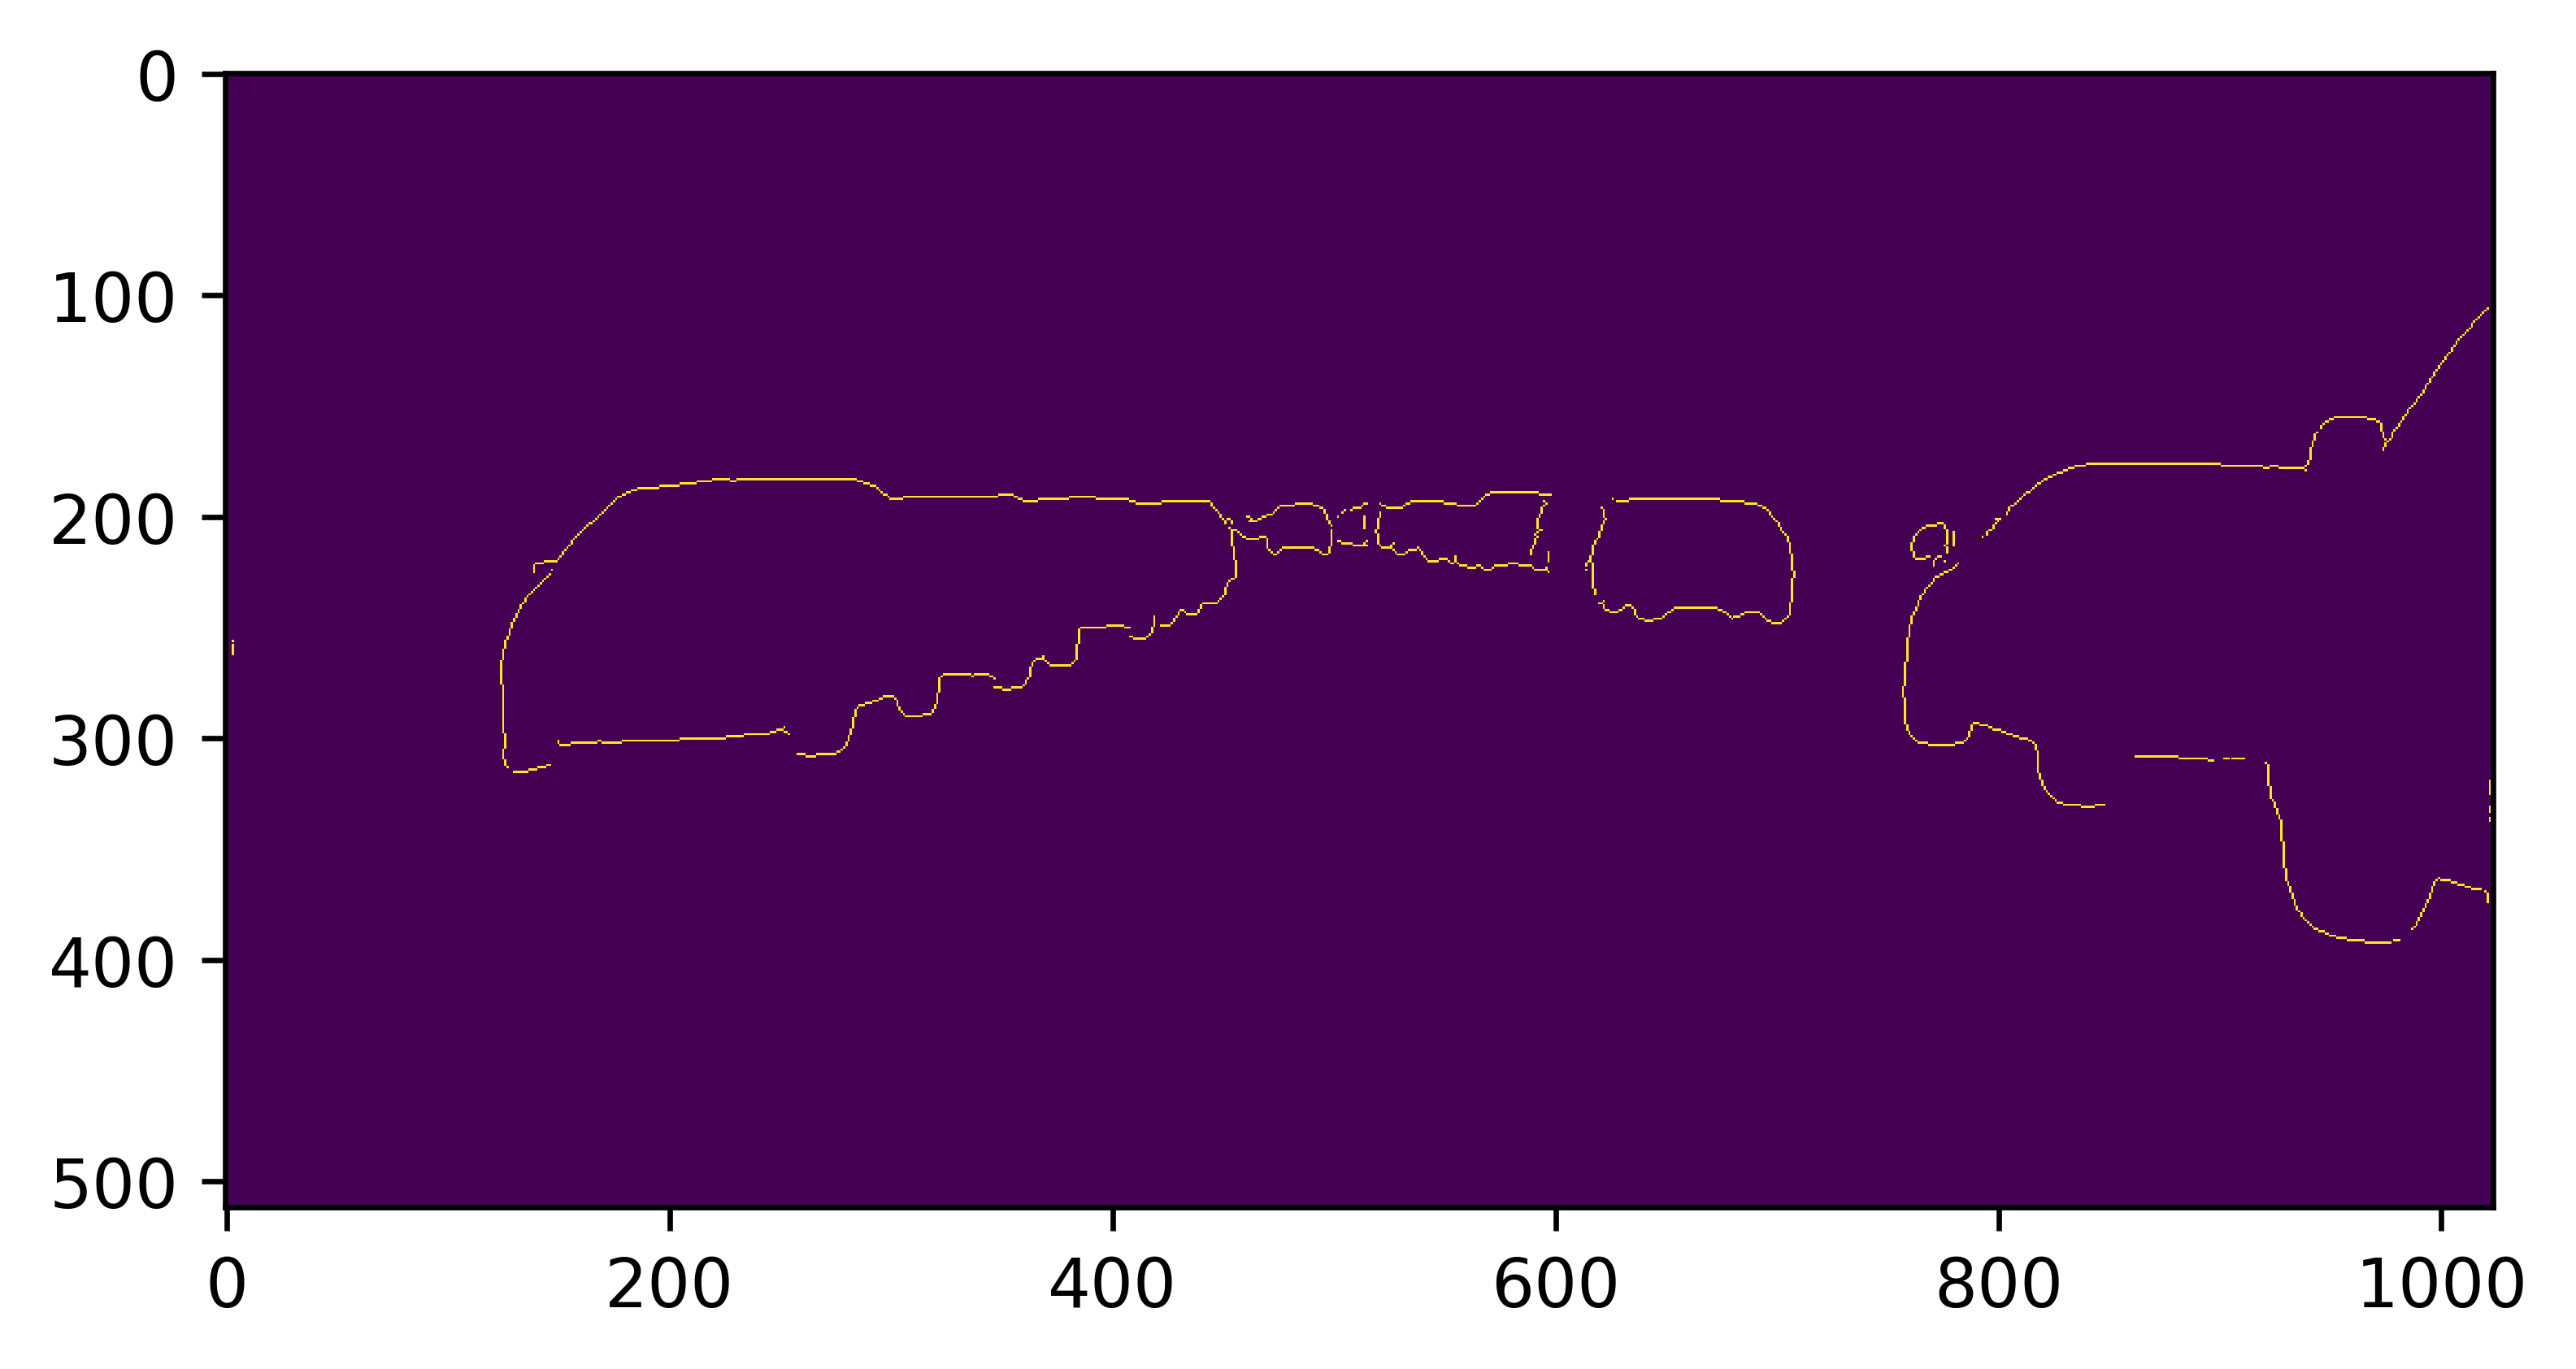

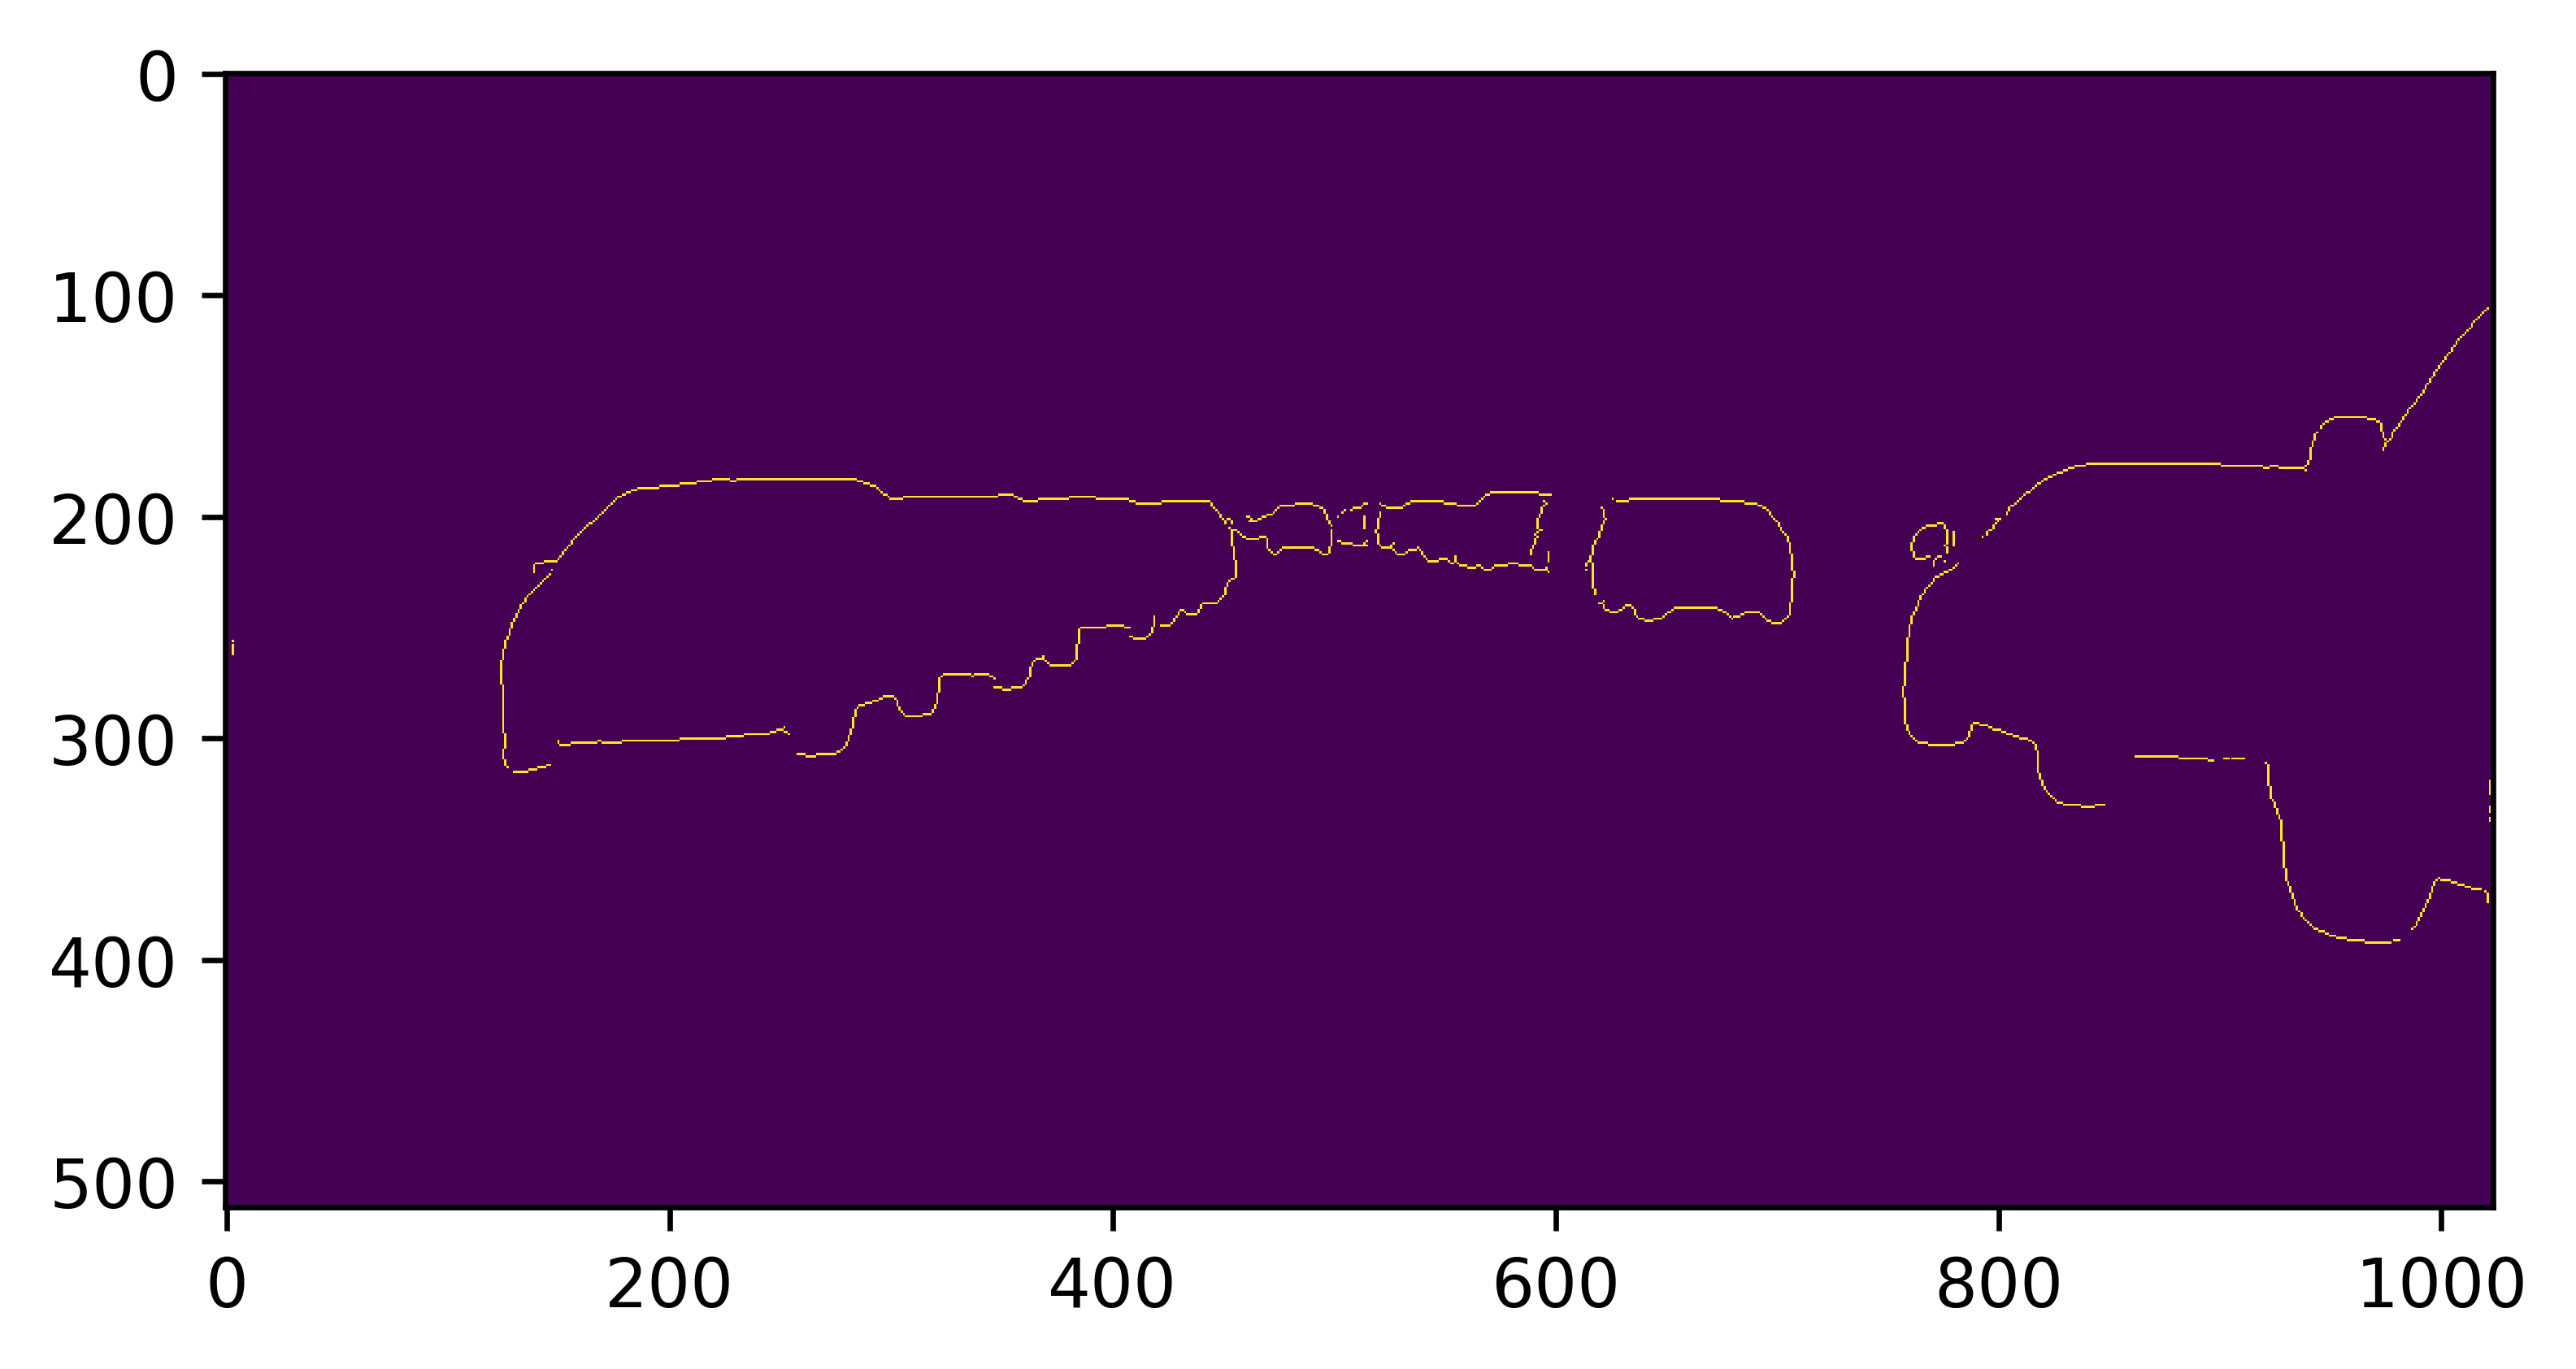

In [70]:
thinned = binary_thin(t_pred)
plt.imshow(thinned, interpolation='nearest')
plt.gcf().set_dpi(600)
plt.show()

thinned = bwmorph_thin(t_pred)
plt.imshow(thinned, interpolation='nearest')
plt.gcf().set_dpi(600)
plt.show()

In [71]:
from pyEdgeEval._lib import correspond_pixels

In [74]:
gt = edge[cat]

In [75]:
match1, match2, cost, oc = correspond_pixels(
    thinned, gt, max_dist=0.02
)
match1 = match1 > 0
match2 = match2 > 0

# Recall
sum_r = gt.sum()
count_r = match2.sum()

# Precision
# TODO: check if using pred after kill_internal is correct
sum_p = pred.sum()
count_p = match1.sum()

In [76]:
print(sum_r, count_r)

4591 2134


In [77]:
print(sum_p, count_p)

10343.243137254905 2134


considering that the recall rate is so low, it might be that the ground truth edges might be thicker than predicted.